In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from robust_PDE_FIND import RobustPCA
from best_subset import *
from UBIC import *
from solvel0 import solvel0

from sklearn.decomposition import PCA, TruncatedSVD
from skimage.restoration import denoise_wavelet, estimate_sigma

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([-1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/KdV_sine_rep_big.mat')
u = (data['usol']).real
x = data['x'][0]
t = data['t'][0]
print("Domain shape:", u.shape)
dt = t[1]-t[0]
dx = x[1]-x[0]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

Domain shape: (512, 501)


#### Visualization

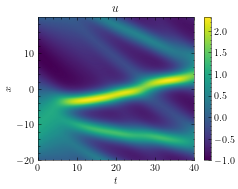

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    ufig.savefig("../Figures/kdv.png", dpi=300)
    plt.show()

In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=2, time_diff = 'FD', space_diff = 'FD')
# Solve with STRidge using 2-norm normalization
w = TrainSTRidge(R,Ut,1e-6,1,l0_penalty=1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1
PDE derived using STRidge
u_t = (-1.000814 +0.000000i)uu_{x}
    + (-1.002643 +0.000000i)u_{xxx}
   


#### Add noise

In [5]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*abs(noise_lv)*u.std()*np.random.randn(*u.shape)

In [6]:
print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

107.2604701886334 92.92276051387736


#### Use the precomputed denoised variable given by the K-SVD

In [7]:
is_u_denoised = True
if is_u_denoised:
    print("Loading denoised data...")
    # denoised_un = np.load("./denoised_files/KdV_rep_sine_noise30_reduced_dctV2ksvdreg_25x25.npy")
    # un = denoised_un
    
    ### PCA ###
#     target_percentage = 95
#     summ = 0.0
#     n_components = 0
#     sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(sigma)
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### Revised PCA ###
#     target_percentage = 99.5
#     Sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     # sigma = Sigma/Sigma.sum() # if .explained_variance_ is used above
#     summ = np.cumsum(100*Sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     print(n_components, summ[n_components-1])
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### SVD ###    
#     target_percentage = 99.99 # 90, 95, 99.99
#     U, Sigma, V = np.linalg.svd(un, full_matrices=False); V = V.T
#     sigma = (Sigma.copy())**2
#     sigma = sigma/sigma.sum()
#     summ = np.cumsum(100*sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     svd_un = U[:, 0:n_components].dot(np.diag(Sigma[0:n_components]).dot(V[:,0:n_components].T))
#     print(n_components, summ[n_components-1])
#     un = svd_un
    
    ### Wavelet denoising ###
#     wavelet_un = denoise_wavelet(un, channel_axis=None, convert2ycbcr=False, 
#                                  sigma=estimate_sigma(un, channel_axis=None, average_sigmas=True), 
#                                  method='BayesShrink', mode='soft', rescale_sigma=True)
#     un = wavelet_un

    ### Robust PCA ###
#     rpca_lam = 0.1
#     un, _ = RobustPCA(un, rpca_lam)

    ### FFT ###
    def remove_f(uu, percent):
        if percent <= 0: return uu
        # PSD = (uu*np.conj(uu)) # also valid
        PSD = (uu*np.conj(uu))/np.prod(uu[0, :].shape)
        PSD = PSD.real
        mask = (PSD>=np.percentile(PSD, percent)).astype(np.float32)
        return uu*mask
    remove_percent = 50
    un = ifft(remove_f(fft(un), remove_percent)).real
    
    l_F, l_inf = np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf)
    print(l_F, l_inf)

Loading denoised data...
98.79120257251398 88.75426324023974


#### Applying best-subset regression on the weak formulation

In [8]:
differentiation_method, differentiation_kwargs = ps.FiniteDifference, {}
diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [9]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2+1, lam=1e-4, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, alpha=1e-4, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
print(model.get_feature_names())
X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
['u', 'uu', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11', 'uu_111', 'uuu_111', 'uu_1111', 'uuu_1111']


In [10]:
solvel0(X_pre, y_pre, intercept=False, refine=True)

100%|█████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.78it/s]


[(6,),
 (4, 6),
 (2, 4, 6),
 (2, 4, 6, 7),
 (2, 3, 4, 6, 9),
 (2, 4, 6, 8, 9, 12),
 (2, 4, 6, 8, 9, 10, 12),
 (2, 4, 6, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 7, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

In [11]:
bf_solve, best_subsets = brute_force_all_subsets(X_pre, y_pre) # compare solvel0's res to bf_solve
best_subsets

100%|█████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.23s/it]


[(6,),
 (4, 6),
 (2, 4, 6),
 (2, 4, 6, 10),
 (2, 3, 4, 6, 9),
 (2, 4, 6, 8, 9, 12),
 (2, 4, 6, 8, 9, 10, 12),
 (2, 4, 6, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 7, 8, 9, 10, 12, 13),
 (2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13),
 (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

#### Model selection by the UBIC (Algorithm 1)

In [12]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
# scale = 1
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
# 2.279718223696011
last_lam, last_ubic, last_bc, best_bc

threshold 4.937704482204366
1 <---> 1 inf
1 <---> 2 0.0017166050323214148


(2.20948232088303,
 array([  3727.05172912, -17496.90893119, -17174.66681659, -17117.50303486,
        -16768.17361546, -16931.47780535, -16875.07390485, -16679.88848084,
        -16184.62967666, -15133.56876262, -14261.60071663, -13722.55418995,
        -13428.72463546, -11871.60394286]),
 1,
 1)

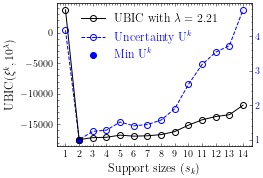

In [13]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
#     ax.annotate('$(u_{xxx}, uu_{x})\checkmark$', fontsize=15, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]-0.25, last_ubic[best_bc]+15000), 
#                  va = "top", ha="left" )
#     ax.annotate('', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.25, last_ubic[best_bc]+12500), 
#                  arrowprops={'arrowstyle': '->'}, va = "top", ha="left" )
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12, bbox_to_anchor=(-0.025,0,1,1))
    
    plt.show()

#### Percent coefficient error

In [14]:
# print(n_components, summ[n_components-1])
print(l_F, l_inf)

98.79120257251398 88.75426324023974


In [15]:
# (9.298658531833038, 0.3296650241818915)
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

(17.467630787931235, 1.3825286572947295)

In [16]:
# rksvd: 28.374278117692345 41.00230766311467 | (9.298658531833038, 0.3296650241818915)
# svd n_comp=314: 104.72815680941093 91.521686604075 | (17.095722657699028, 1.354490847495482)
# svd n_comp=370: 106.37520628334629 92.31861847677209 | (17.26487523732748, 1.3721154712296961)
# svd 99.5: 107.23354108345544 92.97858828858716 | (17.331158549087068, 1.3728967977272966)
# pca n_comp=5: 51.6717038699047 67.5005060254415 | - 3 selected
# pca n_comp=71: 67.30325440550767 67.91597565257624 | (13.788902069020992, 0.9871844615985452)
# pca 99.5: 103.95542664281989 91.25328339557271 | (17.340102223137137, 1.3736514471867691)
# Robust PCA: 104.83186085874482 91.74189210872163 | (16.54620706202549, 1.3764918934751904)
# wavelet: 24.22240598550411 40.00186409220125 | (14.42596824254534, 1.1386675587069082)
# FFT_{10}: -
# FFT_{25}: -
# FFT_{50}: 98.79120257251398 88.75426324023974 | (17.467630787931235, 1.3825286572947295)

### revised SVD (max = 99.99) ###
# 5 90.20611814446616
# 51.44220341112509 67.12317425219678 -> Failed
# 71 95.0219731316148
# 67.73313400193071 67.92078007013038 -> (13.678532558121436, 1.032721833041994)
# 297 99.50048060458256
# 103.9727266389419 91.04782829638438 -> Failed
# 450 99.99047926805933
# 107.1987585572404 93.00114762774733 -> (17.295907528995045, 1.3698745184368857)
### revised PCA (max = 99.5) ###
# 5 90.22134499164251
# 51.6717038699047 67.5005060254415 -> Failed
# 71 95.03508461835614
# 67.30325440550767 67.91597565257624 -> (13.788902069020992, 0.9871844615985452)
# 297 99.50437003249274
# 103.95542664281989 91.25328339557271 -> (16.54620706202549, 1.3764918934751904)

In [17]:
tau = 3 # we fix its value as a constant
scale = np.log(len(y_pre))
# scale = 1
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp >= thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
# 2.279718223696011
last_lam, last_ubic, last_bc, best_bc

threshold 4.937704482204366
1 <---> 1 inf
1 <---> 2 0.0017166050323214148


(2.20948232088303,
 array([  3727.05172912, -17496.90893119, -17174.66681659, -17117.50303486,
        -16768.17361546, -16931.47780535, -16875.07390485, -16679.88848084,
        -16184.62967666, -15133.56876262, -14261.60071663, -13722.55418995,
        -13428.72463546, -11871.60394286]),
 1,
 1)